In [36]:
%load_ext autoreload
%autoreload 2

# --------------------------------------------------------------------------------

import os
import sys
from pathlib import Path
import numpy as np
np.warnings.filterwarnings('ignore')

# hex2cec
HOME = os.environ["HOME"]

sys.path.insert(0, f"{os.environ['HOME']}/hex2vec")
sys.path.insert(0, f"{os.environ['HOME']}/amazon-routing-challenge")

# add codebase
sys.path.insert(0, f"/gcsmount-notebook/codebase")

from src.data.make_dataset import h3_to_polygon
import urban_tools.constants as uc
import urban_tools.hex_pipeline as hp
from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
from urban_tools.pipelines import route_hex_pipeline
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd
import h3
import gcsfs

%matplotlib inline
import matplotlib.pyplot as plt
## Read in the DataFrame

p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/12.12.22-Revised-Embeddings/hh.pkl")
hh = RouteHexHandler.from_pickle(p)
hh.print_history()
hh = hh.drop_zero_tags()
### Drop Tags that occur in <X% of a City
# percentage = 0.01
# import pandas as pd

# drop_cols = pd.Index([])
# for _hh in [hh]:
#     assert _hh.df["city"].unique().shape[0] == 1
#     h3_df = _hh.df.groupby('h3')[_hh.all_tags].first()
#     percent_occurance = (h3_df > 0).sum() / h3_df.shape[0]
#     drop_cols = drop_cols.union(percent_occurance[percent_occurance < percentage].index)
# hh.drop_cols(drop_cols)
# len(hh.all_tags)
### Append the embedding to the dataframe
# embedding_df = pd.read_parquet(
#     hh.my_folder / "embeddings.prq"
# )
embedding_df = pd.read_feather(
    "/gcsmount-research-data-staging/hex2vec-models/paper-final/embedding_dfs/subtags+cities+littlemodel.feather"
)
embedding_df = embedding_df.set_index("h3")
# embedding_df.columns = [f"e_{e}" for e in embedding_df.columns]
# embedding_df = embedding_df[embedding_df.columns.str.]
# embedding_columns = embedding_df.columns.copy()
# embedding_df = embedding_df.reset_index()

hh.df = hh.df.merge(embedding_df, on="h3", how="left")
hh.update_tags()
hh.df = hh.df.dropna(subset=hh.embeddings)
### Filter for only H3 with > X Data Points

# tagged_df = tagged_df.loc[tagged_df["h3_9"] > 20].copy()
hh.df = hh.df[hh.df.city.str.contains('Boston')]
# hh.df.drop("h3_9", axis=1, inplace=True)
# print(tagged_df.shape)
hh.df = hh.df.reset_index(drop=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
read_cities(*(PosixPath('/gcsmount-research-data-staging/osmnx-cities/hexed-complete'),), **{'cities': ['Boston, USA', 'Austin, USA', 'Seattle, USA', 'Los Angeles, USA'], 'add_city_col': True})
create_super_tags(*(), **{})
Merge building_residential + building_house -> building_yes(*(), **{})
drop_zero_buildings(*(), **{})
drop_zero_building_area(*(), **{})
add_new_special_tag(*('building.area.average',), **{})
add_new_special_tag(*('parking.area.average',), **{})
append_route_df(*(), **{'grouped': False, 'tukey_fences': False})
open_route_df(*(), **{'grouped': False, 'tukey_fences': False})
drop_zero_tags(*(), **{})


In [37]:
hh = hh.filter_hex_occurance(20)

### Create the TT Manager

In [38]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from scipy.stats import pearsonr

In [39]:
tt = TestTrainManager(
    hh.df,
    x_col=hh.embeddings.union(hh.special_tags).union(hh.super_tags),
    y_col=["planned_service_time_log"],
    scaler=RobustScaler,
    grouped=False,
    desired_quantiles=[0.5, 0.90]
)

tt.split_test_train(train_size=0.8, random_seed=42)
tt.scale_test_train()
# split the tt.X_test into several chunks. Have to do this because of memory issues
tt.build_test_df(agg=False)

In [40]:
h3_train_index = hh.df.loc[tt._train_slice, 'h3']
y_data = pd.DataFrame(data=tt.Y_train.values, index=h3_train_index, columns=['Y_train'])
y_train_df = pd.DataFrame(index=list(dict.fromkeys(h3_train_index)))
y_train_df['mean'] = y_data.groupby('h3')['Y_train'].mean()
y_train_df['std'] = y_data.groupby('h3')['Y_train'].std()
X_train = tt.X_train.groupby(h3_train_index).first().values
X_train.shape, y_train_df['mean'].shape

((316, 74), (316,))

In [41]:
h3_test_index = hh.df.loc[tt._test_slice, 'h3']
y_data = pd.DataFrame(data=tt.Y_test.loc.values, index=h3_test_index, columns=['Y_test'])
y_test_df = pd.DataFrame(index=list(dict.fromkeys(h3_test_index)))
y_test_df['mean'] = y_data.groupby('h3')['Y_test'].mean()
y_test_df['std'] = y_data.groupby('h3')['Y_test'].std()
X_test = tt.X_test.groupby(h3_test_index).first().values
X_test.shape, y_test_df['mean'].shape

((79, 74), (79,))

## PCA

In [42]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import statistics as stat
from sklearn.linear_model import LinearRegression
import math
from sklearn import metrics
%matplotlib inline

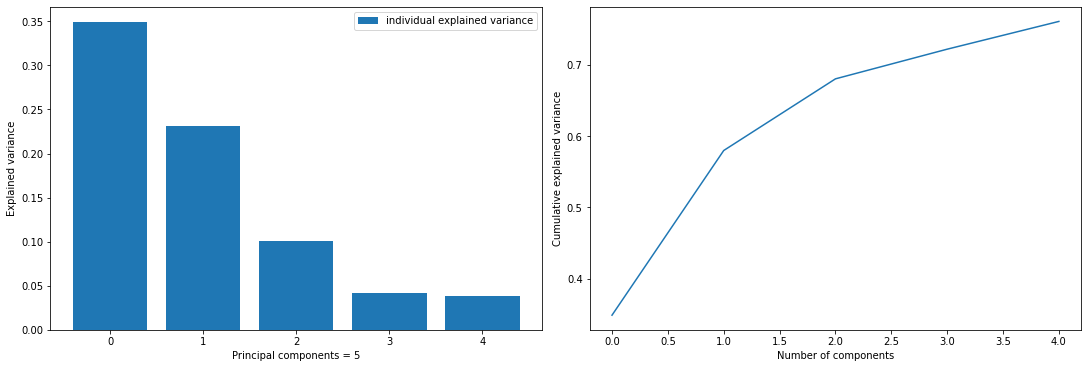

In [43]:
# n_components = X_train.shape[1]
n_components = 5
pca = PCA(n_components=n_components)
# pca = KernelPCA(n_components=n_components, kernel='rbf', gamma=0.1)
X_pca = pca.fit_transform(X_train)

# explained_variance = np.var(X_pca, axis=0) / np.sum(np.var(X_pca, axis=0))

def plot_pca(n_components, explained_variance):
    # create subplots for cumulative explained variance and individual explained variance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # plot individual explained variance
    ax1.bar(range(n_components), explained_variance, label='individual explained variance')
    ax1.set_xlabel(f'Principal components = {n_components}')
    ax1.set_ylabel('Explained variance')
    ax1.legend()

    # plot cumulative explained variance
    ax2.plot(np.cumsum(explained_variance))
    ax2.set_xlabel('Number of components')
    ax2.set_ylabel('Cumulative explained variance')

    plt.show()

explained_variance=pca.explained_variance_ratio_
plot_pca(n_components, explained_variance)

## Modelling using GP Regression

In [44]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Make plots inline
%matplotlib inline

In [45]:
# data_dim = X_train.shape[1]

# # Same architechture as the MLP neural network
# class LargeFeatureExtractor(torch.nn.Sequential):
#     def __init__(self):
#         super(LargeFeatureExtractor, self).__init__()
#         self.add_module('linear1', torch.nn.Linear(data_dim, 16))
#         self.add_module('relu1', torch.nn.ReLU())
#         self.add_module('linear2', torch.nn.Linear(16, 32))
#         self.add_module('relu2', torch.nn.ReLU())
#         self.add_module('linear3', torch.nn.Linear(32, 128))
#         self.add_module('relu3', torch.nn.ReLU())
#         self.add_module('linear4', torch.nn.Linear(128, 32))
#         self.add_module('relu4', torch.nn.ReLU())
#         self.add_module('linear5', torch.nn.Linear(32, 16))
#         self.add_module('relu5', torch.nn.ReLU())
#         self.add_module('linear6', torch.nn.Linear(16, 2))

# feature_extractor = LargeFeatureExtractor()

In [46]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.base_covar_module = gpytorch.kernels.RBFKernel()
            self.covar_module = gpytorch.kernels.AdditiveStructureKernel(
                gpytorch.kernels.ScaleKernel(
                    gpytorch.kernels.GridInterpolationKernel(self.base_covar_module, grid_size=128, num_dims=1)
                ), num_dims=train_x.shape[-1]
            )
            # This leads to crashing of the kernel :/
            # gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=n_components)),
            #     num_dims=n_components, grid_size=64
            # )
            # self.feature_extractor = feature_extractor

            # self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            #     num_dims=2, grid_size=256
            # )

            # PCA based feature extractor
        
            self.feature_extractor = PCA(n_components=n_components)

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # projected_x = self.feature_extractor(x)
            projected_x = torch.Tensor(self.feature_extractor.fit_transform(x))
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [47]:
from tqdm import tqdm
training_iterations = 1000

# load the saved model
# state_dict = torch.load('model_state.pth')

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(torch.Tensor(X_train), torch.Tensor(y_train_df['mean'].values), likelihood)

# model.load_state_dict(state_dict)

if torch.cuda.is_available():
    model = model
    likelihood = likelihood

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    # {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()}, 
    {'params': model.likelihood.parameters()},
], lr=1e-2)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

train_losses = []

def train():
    iterator = tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(torch.Tensor(X_train))
        # Calc loss and backprop derivatives
        loss = -mll(output, torch.Tensor(y_train_df['mean'].values))
        loss.backward()
        train_losses.append(loss.item())
        iterator.set_postfix(loss=loss.item())
        optimizer.step()

%time train()

100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s, loss=0.418]

CPU times: user 12min 5s, sys: 4min 28s, total: 16min 33s
Wall time: 3min 42s


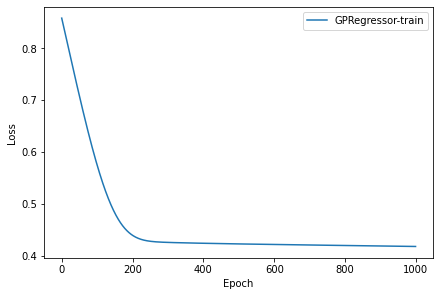

In [48]:
# plot the loss
plt.plot(train_losses, label='GPRegressor-train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    training_preds = model(torch.Tensor(X_train))

# Testing on the hexagonal level though
h3_index = hh.df.loc[tt._test_slice, 'h3']
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(torch.Tensor(tt.X_test.groupby(h3_index).first().values))

In [50]:
# # This is wrong and messes up the predictions
# preserved_unique_h3_index = list(dict.fromkeys(hh.df.loc[tt._test_slice, 'h3']))
# y_test_df = pd.DataFrame(index=preserved_unique_h3_index)
# y_test_df['mean'] = tt.scaler.Y.transform(hh.df.loc[tt._test_slice, 'planned_service_time_log'].groupby(h3_index).mean().values.reshape(-1,1)).ravel()
# y_test_df['std'] =  tt.Y_test.loc.groupby(h3_index).std().values.ravel()
# y_test_std = y_test_df['std']
# # y_data = pd.DataFrame({'y_test':y_test, 'y_test_mean_pred':preds.mean.ravel()}, index = h3_index)

In [51]:
print('Mean-predicitions')
print(f"Train MAPE: {mean_absolute_percentage_error(y_train_df['mean'].values, training_preds.mean):.3f}, Train RMSE: {mean_squared_error(y_train_df['mean'].values, training_preds.mean, squared=False):.3f}, Train R2: {r2_score(y_train_df['mean'].values, training_preds.mean):.3f}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test_df['mean'].values, preds.mean):.3f}, Test RMSE: {mean_squared_error(torch.Tensor(y_test_df['mean'].values), preds.mean, squared=False):.3f}, Test R2: {r2_score(torch.Tensor(y_test_df['mean'].values), preds.mean):.3f}")
print('-'*50)
print('Variance-predicitions')
# np.where(y_test_std.isna())
# nnull = np.where(y_test_std.notnull())[0]
# print(f'Train MAPE: {mean_absolute_percentage_error(tt.Y_train.scale, training_preds.variance**0.5):.3f}, Train RMSE: {mean_squared_error(tt.Y_train.scale, training_preds.variance**0.5, squared=False):.3f}, Train R2: {r2_score(tt.Y_train.scale, training_preds.variance**0.5):.3f}')
print(f"Test MAPE: {mean_absolute_percentage_error(y_test_df['std'].values, preds.variance**0.5):.3f}, Test RMSE: {mean_squared_error(y_test_df['std'], preds.variance**0.5, squared=False):.3f}, Test R2: {r2_score(y_test_df['std'], preds.variance**0.5):.3f}")


torch.save(model.state_dict(), './hex_model_state.pth')

Mean-predicitions
Train MAPE: 1.013, Train RMSE: 0.366, Train R2: 0.000
Test MAPE: 1.005, Test RMSE: 0.290, Test R2: -0.000
--------------------------------------------------
Variance-predicitions
Test MAPE: 0.965, Test RMSE: 0.590, Test R2: -35.779


## Trying to understand intra hex variance now

* get empirical points for every hexagon!

In [52]:
empirical_pts_df = hh.df.loc[hh.df['h3'].isin(y_test_df.index)].groupby('h3').apply(lambda x: x['planned_service_time'].values)
empirical_pts_df = empirical_pts_df[y_test_df.index]
# y_test_std = np.array([tt.scaler.Y.transform(x.reshape(-1, 1)).std() for x in empirical_pts_df.values])

In [53]:
# difference between predicted and empiral distribution hexagon wise

# 1. using predictions from GP Regression model
import scipy

test_df = tt.X_test.groupby(h3_index).first()

# conversion of log mean and std to the original scale
test_df['actual_mean'], test_df['actual_std'] = np.array([x.mean() for x in empirical_pts_df.values]), np.array([x.std() for x in empirical_pts_df.values])

pred_mean, pred_std = tt.scaler.Y.inverse_transform(preds.mean.reshape(-1, 1)), tt.scaler.Y.inverse_transform((preds.variance**0.5).reshape(-1, 1))

In [54]:
# y_pred_samples = np.exp(np.random.normal(loc=pred_mean, scale=pred_std, size=(test_df.shape[0], 10000)))
y_pred_samples = np.exp(tt.scaler.Y.inverse_transform(np.random.normal(loc=preds.mean.reshape(-1, 1), scale=(preds.variance**0.5).reshape(-1, 1), size=(test_df.shape[0], 10000)).flatten().reshape(-1, 1)).reshape(test_df.shape[0], 10000))
test_df['pred_mean'], test_df['pred_std'] = y_pred_samples.mean(axis=1), y_pred_samples.std(axis=1)

#### Wasserstein Distance between predicted distribution and empirical points: 

In [55]:
waserstein_distance = []
for group in hh.df.loc[hh.df['h3'].isin(test_df.index)].groupby('h3'):
    id_ = test_df.index.get_loc(group[1]['h3'].tolist()[0])
    waserstein_distance.append([group[1]['h3'].tolist()[0],scipy.stats.wasserstein_distance(y_pred_samples[id_], empirical_pts_df.values[id_])])

test_df = test_df.join(pd.DataFrame(waserstein_distance).set_index(0)).rename(columns={1:'wasserstein_distance'})

In [56]:
hh.df.loc[hh.df['h3'].isin(test_df.index)][['lat','lng', 'planned_service_time']].to_csv('scatter_points.csv')

In [57]:
test_df.head()

,aeroway,amenity,building,building.area,building.area.average,building.area.ratio,e_0,e_1,e_10,e_11,...,shop,sport,tourism,water,waterway,actual_mean,actual_std,pred_mean,pred_std,wasserstein_distance
h3,,,,,,,,,,,,,,,,,,,,,
892a30640b7ffff,0.0,0.000000,-1.442105,-0.773057,4.704461,-0.774415,0.544680,-1.125771,-0.137526,0.148714,...,0.0,0.0,0.0,0.0,0.0,111.159524,73.246976,112.725326,2.864444,54.532392
892a3064107ffff,0.0,1.666667,-0.547368,-0.386710,0.627732,-0.386967,-1.922401,-1.182858,0.729367,-0.762619,...,0.0,0.0,0.0,0.0,1.0,125.814286,67.020710,112.773241,2.779479,44.777253
892a306410bffff,0.0,1.500000,-0.178947,-0.237239,0.210226,-0.237321,-0.947338,-0.533132,0.753293,-0.489111,...,8.0,0.0,1.0,0.0,0.0,136.855556,114.167565,112.819171,2.679151,66.773248
892a3064117ffff,0.0,5.166667,-0.610526,-0.676682,0.212751,-0.677530,-1.000626,-1.060873,1.089153,-0.680656,...,1.0,3.0,0.0,0.0,2.0,265.950000,201.007581,112.776415,2.688723,161.692572
892a3064137ffff,0.0,-0.166667,-0.189474,-0.295949,0.141052,-0.295869,-0.925700,-0.883623,1.079081,-1.244580,...,0.0,0.0,0.0,0.0,1.0,210.374359,120.199374,112.842486,2.672510,106.176053


In [58]:
largest_var_df = test_df.nlargest(100, 'wasserstein_distance')
smallest_var_df = test_df.nsmallest(100, 'wasserstein_distance')
largest_var_df.to_csv('intrahex_largest_var_df.csv')
smallest_var_df.to_csv('intrahex_smallest_var_df.csv')

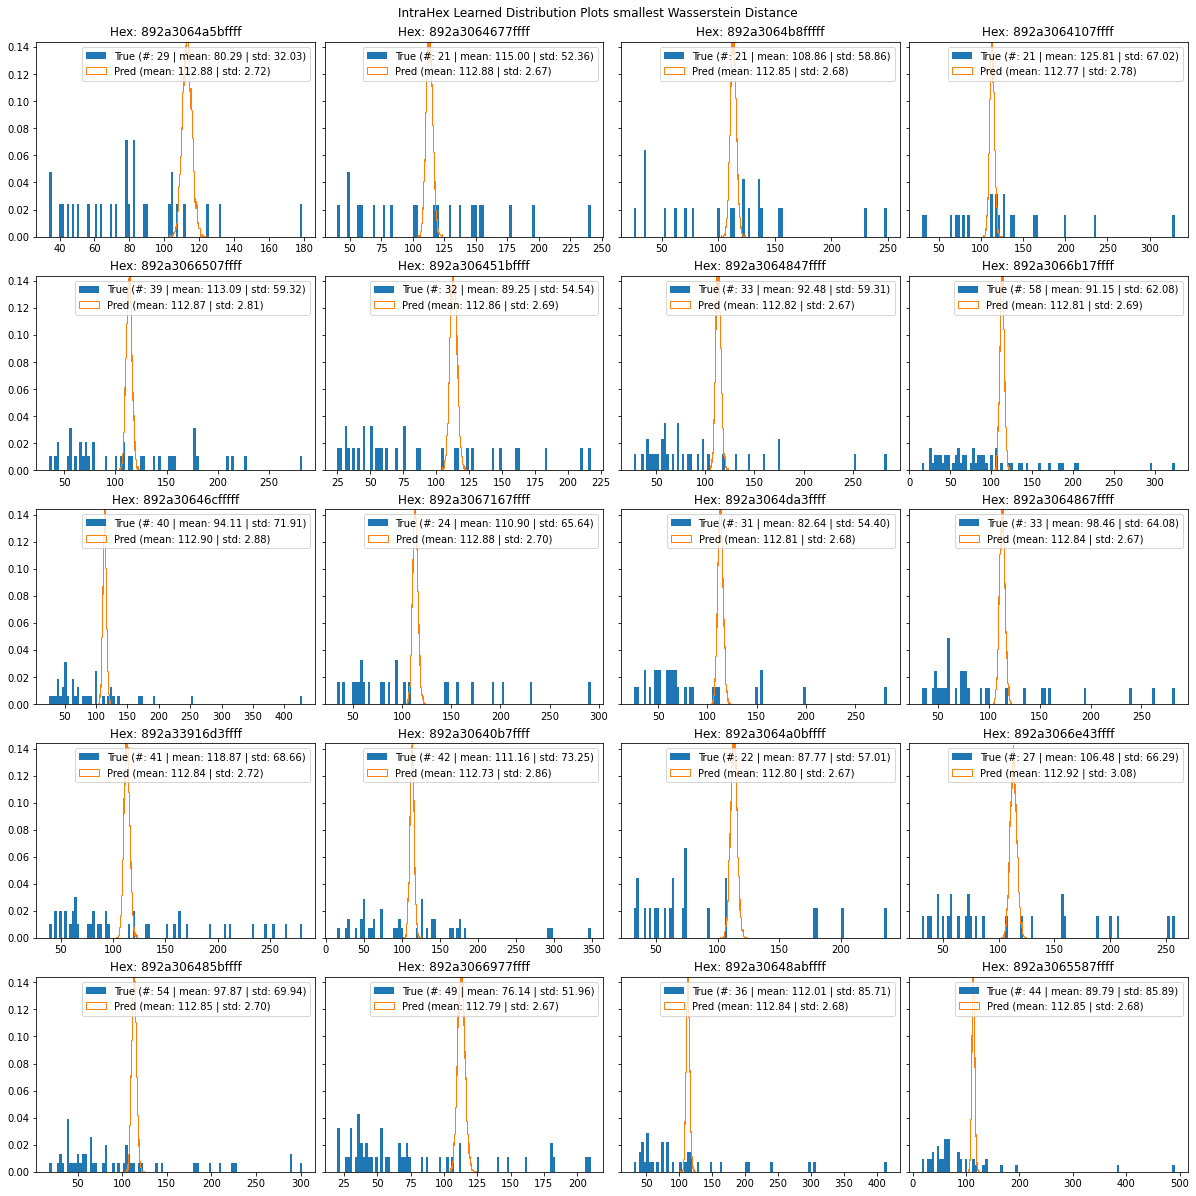

In [59]:
plt.rcParams['figure.constrained_layout.use'] = True
def dist_subplots(df, title):
    rows, cols = 5, 4
    fig, axes = plt.subplots(rows, cols, figsize=(16.5, 16.5), sharey=True)
    fig.suptitle(title)
    count = 0
    for i in range(rows):
        for j in range(cols):
            # emp_pnts = hh.df.loc[hh.df['h3']==df.iloc[count].name]['planned_service_time'].to_list()
            # y_samples = np.random.normal(loc=df.iloc[count]['pred_mean'], scale=df.iloc[count]['pred_std'], size=10000,)
            # y_samples = np.clip(np.exp(y_samples), 0, 10000)
            id_ = test_df.index.get_loc(df.iloc[count].name)
            axes[i, j].hist(empirical_pts_df.values[id_], bins=100, density=True, label=f'True (#: {len(empirical_pts_df.values[id_])} | mean: {test_df.iloc[id_].actual_mean:.2f} | std: {test_df.iloc[id_].actual_std:.2f})')
            axes[i, j].hist(y_pred_samples[id_], bins=100, density=True, histtype='step', label=f'Pred (mean: {test_df.iloc[id_].pred_mean:.2f} | std: {test_df.iloc[id_].pred_std:.2f})')
            axes[i, j].set_title(f'Hex: {df.iloc[count].name}')
            axes[i, j].legend()
            # axes[i, j].set_ylim(0, 1)
            # axes[i, j].set_xlim(0, 1)
            count += 1
    plt.tight_layout()


dist_subplots(smallest_var_df, 'IntraHex Learned Distribution Plots smallest Wasserstein Distance')

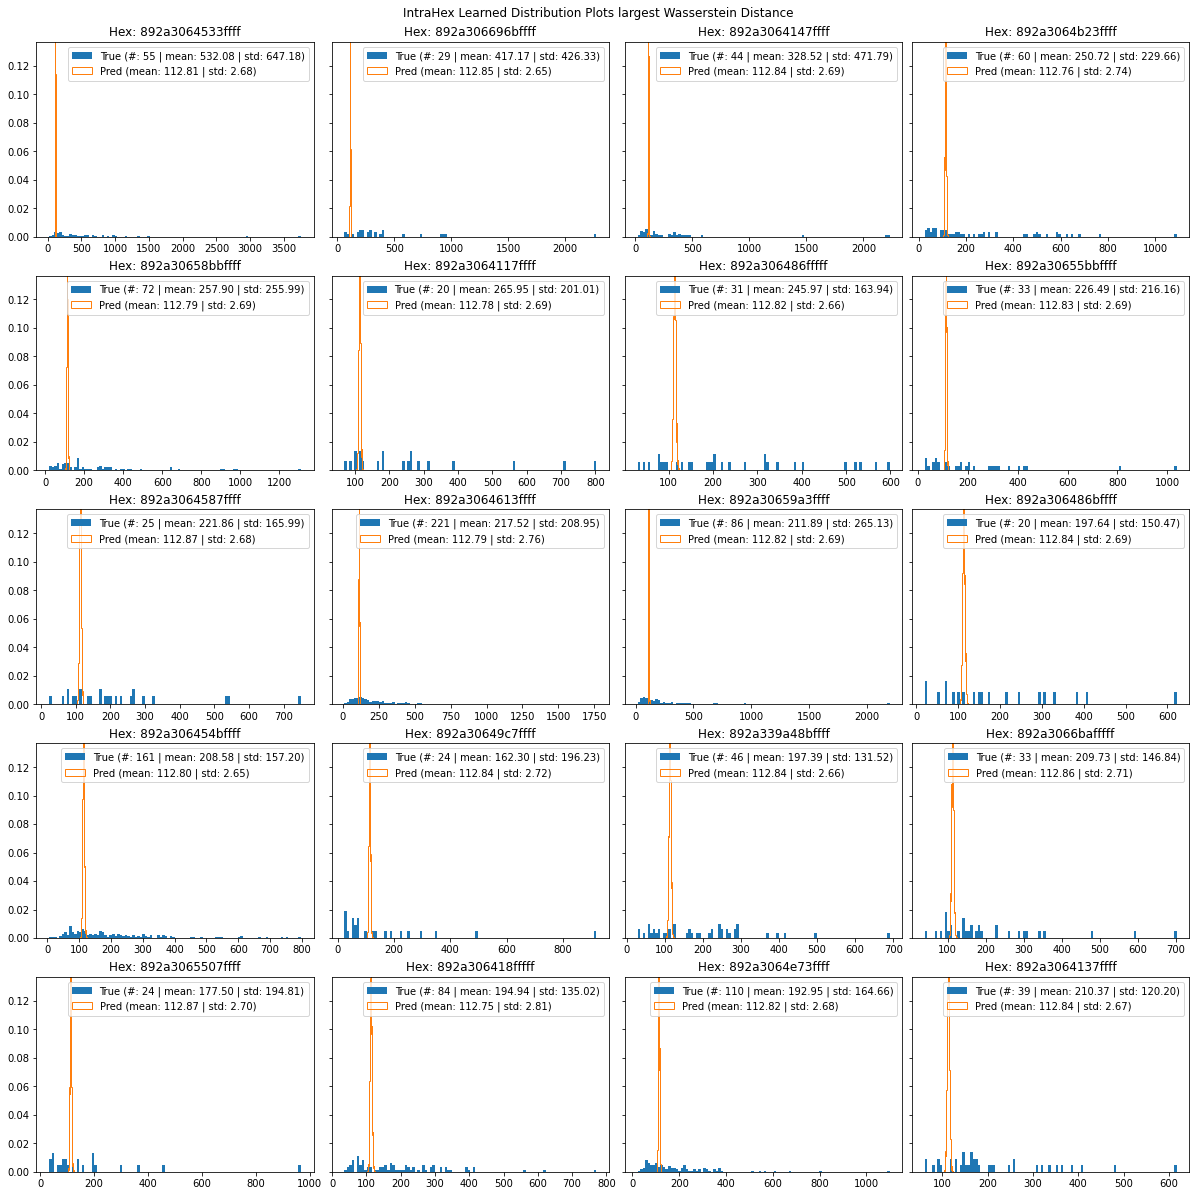

In [60]:
dist_subplots(largest_var_df, 'IntraHex Learned Distribution Plots largest Wasserstein Distance')


### Plot wasserstein distance distribution

<AxesSubplot: title={'center': 'Wasserstein Distance Histogram'}, ylabel='Frequency'>

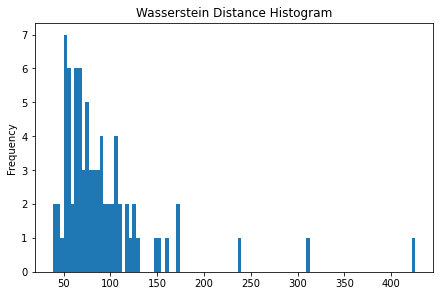

In [61]:
test_df['wasserstein_distance'].plot.hist(bins=100, title='Wasserstein Distance Histogram')